# Session 2: working with Hazards (Tornado and Earthquake)
You will learn how to create earthquake and tornado hazards with IN-CORE in this session.


## 1. Basics of IN-CORE modules

IN-CORE via ```pyincore``` provides a collection of modules that implement functionalities required to access services
that provide access to data, simulation models and their analysis. To use IN-CORE in Jupyter Notebooks, we start by
importing various modules.

#TODO List all modules and short description


We will first focus on how to effectively use the following modules within the IN-CORE architecture to
request information about various hazards and :

* **IncoreClient:** this entity provides access and authentication to IN-CORE services. To access the services, users
  require to have a valid *username* and *password*. Importing ```IncoreClient``` and creating a named instance of the
  client is the first step toward using IN-CORE by establishing a remote connection to various simulation and data
  access services. The variable containing that instance is used by various other services
  to validate the user's identity, as well as provide access to pieces of information required across tasks. *This step
  only needs to be done once.*
* **HazardService:** once the ```IncoreClient``` has been initiated, the ```HazardService``` module uses the information
  from that client to administer existing information about known or new hazards. ```HazardService``` can:
  * Retrieve existing metadata for various hazards
  * Search hazards per specific information
  * Request creation of a new hazard
  * Request deletion of a new hazard

With the latter in mind, let's start by importing these modules and creating our first IN-CORE objects.

In [1]:
# Import modules
from pyincore import HazardService, IncoreClient
import json

In [2]:
# Connect to IN-CORE serivce by creating IncoreClient
# This only needs to be done once as indicated above
client = IncoreClient()

# Create a HazardService instance that depends on the client defined in the previous step
hazardsvc = HazardService(client)

Connection successful to IN-CORE services. pyIncore version detected: 0.9.3


## 2. Tornado hazards
 
We will start by retrieving existing information about a specific tornado, and then using this information to create a slightly modified new tornado hazard scenario. These scenarios are representative of two most frequent tasks with IN-CORE: using prior data to perform post-analysis of hazards, and the creation of new hazards that will become later available. We later also construct an example with a database-driven tornado.

These two tasks alone can enable decision makers to systematically construct, test and refine scenarios, later to be easily shared and discussed across response teams using Jupyter notebooks such as this.


### 2.1 Working with an existing tornado

As with any given hazard, IN-CORE operates by utilizing hazard identification strings (*hazard id*) that uniquely
name existing scenarios and are associated with data and metadata useful for analysis and visualization purposes.
Metadata describe properties of the scenario, such as location

With this identifier, let's perform two tasks:
* Obtain metadata about the tornado
* Obtain hazard values, often used by decision makers during emergency planning and preparation

IN-CORE uses the [JSON lightweight data-interchange format](https://www.json.org/json-en.html) to store and retrieve
hazard information across its services as flexible way to share information in a standardized manner. We will use
Python's ```json``` module to expand that information in a human-readable format.

Let's start by using an identifier for one tornado in Memphis, TN stored as an IN-CORE dataset. 

In [3]:
# Example tornado in Memphis, TN (It's an imaginary tornado)
example_tornado_id = '60a44ae8605f0462bd4263ac'

Now, using the ```HazardService``` module, we retrieve the metadata and display it.

In [4]:
tornado_model_metadata = hazardsvc.get_tornado_hazard_metadata(example_tornado_id)
print(json.dumps(tornado_model_metadata, indent=4, sort_keys=False))

{
    "tornadoType": "model",
    "id": "60a44ae8605f0462bd4263ac",
    "name": "Memphis Tornado model based tornado",
    "description": "mean width tornado hazard",
    "creator": "cwang138",
    "spaces": [
        "cwang138",
        "incore"
    ],
    "date": "2021-05-18T23:16:55+0000",
    "tornadoModel": "MeanWidthTornado",
    "tornadoParameters": {
        "efRating": "EF5",
        "maxWindSpeed": 250.0,
        "startLatitude": 35.135,
        "startLongitude": -90.032,
        "randomSeed": 1234,
        "windSpeedMethod": 1,
        "numSimulations": 1,
        "endLatitude": [
            35.093
        ],
        "endLongitude": [
            -89.801
        ]
    },
    "tornadoWidth": [
        815.9980909090909
    ],
    "efBoxes": [
        {
            "efBoxWidths": [
                0.001002256638187928,
                0.0017328393158413994,
                0.0022321320000668874,
                0.0027387672237662794,
                0.003205018480359198,
    

We will discuss below the meaning of each element in this JSON output. Using the same service, we can obtain specific
data about the hazard, in this case, the hazard values.

In [5]:
# Getting hazard value from your model
points = [
    {
        "demands": ["wind"],
        "units": ["mph"],
        "loc": "35.134, -90.031"
    }
]

tornado_model_vals = hazardsvc.post_tornado_hazard_values(example_tornado_id, points)
print(json.dumps(tornado_model_vals, indent=4, sort_keys=False))

[
    {
        "hazardValues": [
            85.0290143589091
        ],
        "demands": [
            "Wind"
        ],
        "units": [
            "mph"
        ],
        "loc": "35.134, -90.031"
    }
]


Using ```pyIncore_viz```, we can now visualize the tornado hazard:

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


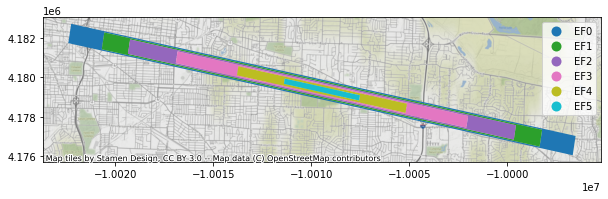

In [6]:
from pyincore_viz.geoutil import GeoUtil as viz
viz.plot_tornado(example_tornado_id, client, basemap=True)

All geographic locations in IN-CORE are specified using the WGS84 coordinate system. Observe that the parameters of the
```json.dumps``` function are as follows:

* the variable containing the resulting metadata
* the indentation used to display the information contained in the JSON format
* whether keys are sorted for convenient reading (no in our case).

### 2.2 Creating model-based tornado

One of IN-CORE strengths is the ability to specify, execute and retrieve information about new hazard scenarios using
the same metadata standard.

As promised above, here is a description of each metadata (JSON) element representing a tornado hazard:

* **tornadoModel** (required) - the tornado model (Mean width will create a tornado using the mean width from historical data for the EF rating)
    * *Mean width tornado (MeanWidthTornado)* - start/end points with a width equal to the average for that EF rating looking at historical tornado data
    * *Random width tornado (RandomWidthTornado) - start/end points, random width selected use the historical data to determine the max width for that tornado rating
    * *Mean Length/Width/angle (MeanLengthWidthAngleTornado)* - start point, length/width and angle are based on the historical average for those attributes based on EF selected
    * *Random length/width/angle (RandomLengthWidthAngleTornado)* - start point, random length/width/angle selected for the ef rating using historical data
    * *Random angle (RandomAngleTornado)* - start point, random angle selected based on historical data.
* *efRating (required)* - a value in the Enhanced Fujita (EF) scale intensity of the tornado (EF0 - EF5)
* *startLatitude/startLongitude (required)* - the starting location of the tornado
* *endLatitude/endLongitude (optional)*- depending on the model, an end latitude/longitude value. Some tornado models (e.g. mean length width, and angle) calcuate endLat and endLon, others (e.g. random angle) will generate multiple endpoints programmatically so the input must be passed as an array
* *windSpeedMethod(optional)* - computation of wind speed within an EF boundary, 0 indicates using linear interpolation, 1 indicates uniform random distribution. Default is Uniform random distribution.

As you may already anticipate, the particular JSON elements vary per each hazard type. We call these *parameters*. Some
parameters are required (i.e. the analysis cannot be performed without them) and others are

##### Random Seeds: about the computational reproducibility of hazard scenarios

Ensuring reproducibility of hazard scenarios is paramount for the IN-CORE team due to its scientific and decision-making
consequences. Hence, care has been exercised to ensure that scenarios can be re-executed consistently in a standardized
and simple manner.

Several models (such as this one) require generating pseudo-random numbers to simulate unexpected natural or human
effects, computational reproducibility of experiments can become somewhat challenging. IN-CORE harnesses the *random
seed*, a special number that determines the exact sequence random number generators (RNGs) produce to ensure
repeatability of that sequence independent of where the code is executed. The ```randomSeed``` parameter in IN-CORE
takes care of this aspect via an integer value that fixes the random number generating process regardless of when the
new analysis is requested or in which infrastructure it is executed.

##### Defining a new (slightly different) tornado

With this information in hand, let's construct a slightly different version of the same tornado. Let us imagine a less
intense scenario with a longer trajectory due to conditions that preserve its energy for a longer time. While path
length have been reported to increase as their EF rating increases, the case we describe here is plausible (See
[On the Relationship of Tornado Path Length and Width to Intensity](https://journals.ametsoc.org/view/journals/wefo/19/2/1520-0434_2004_019_0310_otrotp_2_0_co_2.xml)).

To do so, we will vary:
* the rating in the Enhanced Fujita (EF) rating from ```"EF5"``` to ```"EF4"```,
* the start and end points to have a longer trajectory,
* and the  random number seed to ensure the RNG starts at values different from those in the original scenario.

The result of this process is

```json
{
  "name": "Centerville Model Tornado (modified)",
  "description": "Centerville mean width tornado hazard",
  "tornadoType": "model",
  "tornadoModel" : "MeanWidthTornado",
      "tornadoParameters" : {
      "efRating" : "EF4",
      "startLatitude" : "35.215",
      "startLongitude" : "-97.524",
      "randomSeed" : "1234",
      "endLatitude" : [35.253],
      "endLongitude" : [-97.432],
      "windSpeedMethod" : "1",
      "numSimulations" : "1"
    }
}
```

We now proceed to create the model-based tornado with what we have learned so far. We take care to serialize the Python
dictionary structure into a JSON specification using ```json.dumps```:

In [7]:
# Create a variable to store the new tornado hazard definition:

tornado_model_metadata = {
  "name": "Centerville Model Tornado (modified)",
  "description": "Centerville mean width tornado hazard",
  "tornadoType": "model",
  "tornadoModel" : "MeanWidthTornado",
      "tornadoParameters" : {
      "efRating" : "EF4",
      "startLatitude" : "35.215",
      "startLongitude" : "-97.524",
      "randomSeed" : "3457",
      "endLatitude" : [35.253],
      "endLongitude" : [-97.432],
      "windSpeedMethod" : "1",
      "numSimulations" : "1"
    }
}

tornado_model_json = json.dumps(tornado_model_metadata, indent=4)

Now, we create a tornado scenario, and retrieve the *model response* obtained from requesting IN-CORE to process it:

In [8]:
# Create a tornado with the prior definition
model_response = hazardsvc.create_tornado_scenario(tornado_model_json)
print(json.dumps(model_response, indent=4, sort_keys=False))

{
    "tornadoType": "model",
    "id": "60ac6ca8f076ea45491785ac",
    "name": "Centerville Model Tornado (modified)",
    "description": "Centerville mean width tornado hazard",
    "creator": "vnarah2",
    "spaces": [
        "vnarah2"
    ],
    "date": "2021-05-25T03:19:04+0000",
    "tornadoModel": "MeanWidthTornado",
    "tornadoParameters": {
        "efRating": "EF4",
        "maxWindSpeed": 250.0,
        "startLatitude": 35.215,
        "startLongitude": -97.524,
        "randomSeed": 3457,
        "windSpeedMethod": 1,
        "numSimulations": 1,
        "endLatitude": [
            35.253
        ],
        "endLongitude": [
            -97.432
        ]
    },
    "tornadoWidth": [
        663.9219546174143
    ],
    "efBoxes": [
        {
            "efBoxWidths": [
                0.0008154678223728115,
                0.0013740483453900851,
                0.0019415900532685987,
                0.0024643258368409137,
                0.0029870616204132287
          

As with any analysis, we obtain the identifier of the specific response:

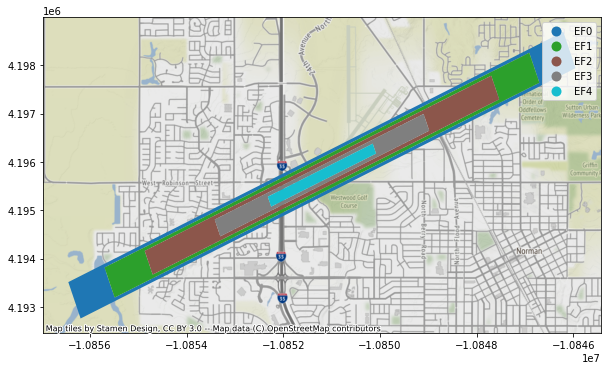

In [9]:
# Acquire hazard id you created
tornado_model_id = model_response['id']
viz.plot_tornado(tornado_model_id, client, basemap=True)

As with the first case, we obtain the hazard values for this tornado:

In [10]:
# Getting hazard value from your model based tornado
points = [
    {
        "demands": ["wind"],
        "units": ["mph"],
        "loc": "35.215, -97.521"
    },
    {
        "demands": ["wind"],
        "units": ["mph"],
        "loc": "35.227, -97.471"
    }
]

tornado_model_vals = hazardsvc.post_tornado_hazard_values(tornado_model_id, points)
print(json.dumps(tornado_model_vals, indent=4, sort_keys=False))

[
    {
        "hazardValues": [
            83.42317153660191
        ],
        "demands": [
            "Wind"
        ],
        "units": [
            "mph"
        ],
        "loc": "35.215, -97.521"
    },
    {
        "hazardValues": [
            0.0
        ],
        "demands": [
            "Wind"
        ],
        "units": [
            "mph"
        ],
        "loc": "35.227, -97.471"
    }
]


### 2.3 Creating a dataset-driven tornado

In some situations, datasets are available outside IN-CORE that determine a hazard. IN-CORE also accepts dataset inputs
to facilitate such analyses. We present here an example of how to do so.

The first step is to construct a hazard dataset description using JSON. In this case, we do so for a tornado in Joplin:

In [11]:
tornado_dataset_data = {
  "name": "Joplin Dataset Tornado - workshop",
  "description": "Joplin tornado hazard with shapefile",
  "tornadoType": "dataset"
}

tornado_dataset_json = json.dumps(tornado_dataset_data, indent=4)

We also specify where the dataset files can be located (in our case, they have been provided to you in the local
directory):

In [12]:
# zip file containing tornado path
file_paths = ["joplin_path_wgs84.shp",
              "joplin_path_wgs84.dbf",
              "joplin_path_wgs84.prj",
              "joplin_path_wgs84.shx"]

Using both, we create a tornado *scenario*:

In [13]:
# Create a tornado with definition and file
dataset_response = hazardsvc.create_tornado_scenario(tornado_dataset_json, file_paths)
print(json.dumps(dataset_response, indent=4, sort_keys=False))

{
    "tornadoType": "dataset",
    "id": "60ac6cac3386d61dcf83a6b2",
    "name": "Joplin Dataset Tornado - workshop",
    "description": "Joplin tornado hazard with shapefile",
    "creator": "vnarah2",
    "spaces": [
        "vnarah2"
    ],
    "date": "2021-05-25T03:19:08+0000",
    "datasetId": "60ac6cacc157585793efc9f0"
}


Similarly, we obtain the identifier of the output to the request (to ```HazardService```):

60ac6cac3386d61dcf83a6b2


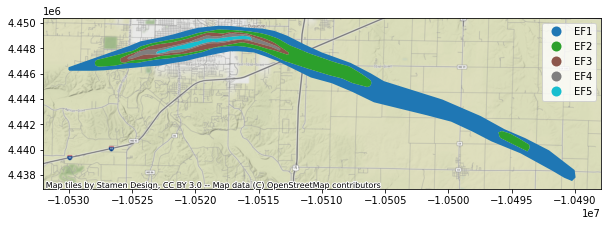

In [14]:
# Acquire hazard id you created
tornado_dataset_id = dataset_response['id']
print(tornado_dataset_id)
viz.plot_tornado(tornado_dataset_id, client, basemap=True)

Finally, we obtain the hazard values as usual.

In [15]:
# Getting hazard value from your dataset-based tornado
points = [
    {
        "demands": ["wind"],
        "units": ["mph"],
        "loc": "37.066, -94.502"
    },
    {
        "demands": ["wind"],
        "units": ["mph"],
        "loc": "37.032, -94.348"
    }
]
tornado_dataset_vals = hazardsvc.post_tornado_hazard_values(tornado_dataset_id, points)
print(json.dumps(tornado_dataset_vals, indent=4, sort_keys=False))

[
    {
        "hazardValues": [
            234.6116829110925
        ],
        "demands": [
            "Wind"
        ],
        "units": [
            "mph"
        ],
        "loc": "37.066, -94.502"
    },
    {
        "hazardValues": [
            94.64611961841487
        ],
        "demands": [
            "Wind"
        ],
        "units": [
            "mph"
        ],
        "loc": "37.032, -94.348"
    }
]


## 3. Earthquake hazards

We will now replicate these steps with a different type of hazards: earthquakes. This implies existing,
model-based and database driven hazard scenarios (deterministic and probabilistic).

### 3.1 Working with existing earthquake hazards

For this case, we will obtain metadata and hazard values for a 7.9 earthquake in Memphis, TN. Since we already have started
the ```IncoreClient``` and ```HazardService objects```, we will not replicate the code here.

{
    "eqType": "model",
    "id": "5b902cb273c3371e1236b36b",
    "name": "Memphis 7.9 AB-95",
    "description": "Memphis new madrid atkinson and boore 1995 model based hazard",
    "date": "2021-05-25T03:19:13+0000",
    "creator": "cnavarro",
    "spaces": [
        "ergo",
        "cnavarro",
        "coe",
        "incore"
    ],
    "attenuations": {
        "AtkinsonBoore1995": 1.0
    },
    "eqParameters": {
        "srcLatitude": 35.927,
        "srcLongitude": -89.919,
        "magnitude": 7.9,
        "coseismicRuptureDepth": 0.0,
        "dipAngle": 0.0,
        "azimuthAngle": 0.0,
        "rakeAngle": 0.0,
        "seismogenicDepth": 0.0,
        "depth": 10.0,
        "depth2p5KmPerSecShearWaveVelocity": 2.0,
        "shearWaveDepth1p0": 0.0,
        "faultTypeMap": {},
        "region": "Global"
    },
    "visualizationParameters": {
        "demandType": "PGA",
        "demandUnits": "g",
        "minX": -90.3099,
        "minY": 34.9942,
        "maxX": -89.6231,
 

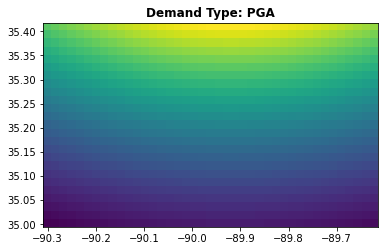

In [16]:
# Example tornado in Memphis, TN
example_earthquake_id = '5b902cb273c3371e1236b36b'

# Obtain and display metadata
earthquake_model_metadata = hazardsvc.get_earthquake_hazard_metadata(example_earthquake_id)
print(json.dumps(earthquake_model_metadata, indent=4, sort_keys=False))

viz.plot_earthquake(example_earthquake_id, client)

In [17]:
# Get hazard values
points = [
    {
        "demands": ["0.2 SA"],
        "units": ["g"],
        "loc": "35.07899, -90.0178"
    },
    {
        "demands": ["0.2 SA", "PGA", "0.8 SA"],
        "units": ["g", "g", "g"],
        "loc": "35.027, -90.077"
    }
]
earthquake_model_vals = hazardsvc.post_earthquake_hazard_values(example_earthquake_id, points)
print(json.dumps(earthquake_model_vals, indent=4, sort_keys=False))

[
    {
        "hazardValues": [
            0.5322993805448739
        ],
        "demands": [
            "0.2 SA"
        ],
        "units": [
            "g"
        ],
        "loc": "35.07899, -90.0178"
    },
    {
        "hazardValues": [
            0.502009539659276,
            0.2596392242939761,
            0.20427888500625907
        ],
        "demands": [
            "0.2 SA",
            "PGA",
            "1.0 SA"
        ],
        "units": [
            "g",
            "g",
            "g"
        ],
        "loc": "35.027, -90.077"
    }
]


### 3.2 Creating model-based earthquakes

Similar to the case of tornadoes, it is possible to create new model-based earthquakes through JSON parameters.


* *attenuations* - attenuation models capture how enery is lost as seismic waves propagate. At present, IN-CORE supports
the following ones:
  * AbrahamsonSilvaKamai2014
  * AtkinsonBoore1995
  * CampbellBozorgnia2014
  * ChiouYoungs2014
* *earthquake position (lat, lon), depth and magnitude* - a description of the location and geophysical properties of
the seismic event
* *demand type and demand units* - a description of the quantity of interest and its units.

Following known steps for model-based tornados, we request computation of a new Memphis earthquake. In this case,
we decrease the depth to 7.0 km and increase the intensity to 8.1.

{
    "eqType": "model",
    "id": "60ac6cb209212c7553ed94dd",
    "name": "Memphis EQ Model (modified)",
    "description": "Memphis model based hazard",
    "date": "2021-05-25T03:19:14+0000",
    "creator": "vnarah2",
    "spaces": [
        "vnarah2"
    ],
    "attenuations": {
        "AtkinsonBoore1995": 1.0
    },
    "eqParameters": {
        "srcLatitude": 35.927,
        "srcLongitude": -89.919,
        "magnitude": 8.1,
        "coseismicRuptureDepth": 0.0,
        "dipAngle": 0.0,
        "azimuthAngle": 0.0,
        "rakeAngle": 0.0,
        "seismogenicDepth": 0.0,
        "depth": 7.0,
        "depth2p5KmPerSecShearWaveVelocity": 2.0,
        "shearWaveDepth1p0": 0.0,
        "faultTypeMap": {},
        "region": "Global"
    },
    "visualizationParameters": {
        "demandType": "PGA",
        "demandUnits": "g",
        "minX": -90.3099,
        "minY": 34.9942,
        "maxX": -89.6231,
        "maxY": 35.4129,
        "numPoints": 1025,
        "amplifyHazard": t

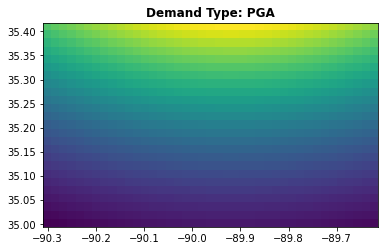

In [18]:
# Define the new earthquake
eq_model_metadata = {
  "name": "Memphis EQ Model (modified)",
  "description": "Memphis model based hazard",
  "eqType": "model",
  "attenuations" : {
    "AtkinsonBoore1995" : "1.0"
  },
  "eqParameters" : {
    "srcLatitude" : "35.927",
    "srcLongitude" : "-89.919",
    "magnitude" : "8.1",
    "depth" : "7.0"
  },
  "visualizationParameters" : {
    "demandType" : "PGA",
    "demandUnits" : "g",
    "minX" :"-90.3099",
    "minY" :"34.9942",
    "maxX" : "-89.6231",
    "maxY" : "35.4129",
    "numPoints" : "1025",
    "amplifyHazard": "true"
  }
}

eq_model_json = json.dumps(eq_model_metadata, indent=4)

# Create an earthquake with definition
eq_model_response = hazardsvc.create_earthquake(eq_model_json)

print(json.dumps(eq_model_response, indent=4, sort_keys=False))

# Acquire hazard id you created
eq_model_id = eq_model_response['id']

# Plot the earthquake
viz.plot_earthquake(eq_model_id, client)

In [19]:
# Getting hazard value from your model based earthquake

points = [
    {
        "demands": ["0.2 SA"],
        "units": ["g"],
        "loc": "35.07899, -90.0178"
    },
    {
        "demands": ["0.2 SA"],
        "units": ["g"],
        "loc": "35.027, -90.077"
    },
]

eq_model_vals = hazardsvc.post_earthquake_hazard_values(eq_model_id, points)
print(json.dumps(eq_model_vals, indent=4, sort_keys=False))

[
    {
        "hazardValues": [
            0.5664133571974412
        ],
        "demands": [
            "0.2 SA"
        ],
        "units": [
            "g"
        ],
        "loc": "35.07899, -90.0178"
    },
    {
        "hazardValues": [
            0.534667651443353
        ],
        "demands": [
            "0.2 SA"
        ],
        "units": [
            "g"
        ],
        "loc": "35.027, -90.077"
    }
]


### 3.3 Creating a dataset-driven earthquake (Probabilistic & Deterministic)

Finally, we show how datasets can drive earthquake scenarios. In this case, both deterministic and probabilistic
alternatives are available. We concentrate here on a deterministic example.

For the example below, the earthquake datasets are provided as TIFF files.

As with the corresponding tornado example, specify the dataset(s) to be used:

In [20]:
eq_dataset_data = {
  "name":"Memphis Deterministic EQ",
  "description":"Memphis dataset based deterministic hazard",
  "eqType":"dataset",
  "hazardDatasets":[
    {
      "hazardType":"deterministic",
      "demandType":"SA",
      "demandUnits":"g",
      "period":"0.2",
      "eqParameters":{
        "srcLatitude":"35.927",
        "srcLongitude":"-89.919",
        "magnitude":"7.9",
        "depth":"10.0"
      }
    },
    {
      "hazardType":"deterministic",
      "demandType":"PGA",
      "demandUnits":"g",
      "period":"0.0",
      "eqParameters":{
        "srcLatitude":"35.927",
        "srcLongitude":"-89.919",
        "magnitude":"7.9",
        "depth":"10.0"
      }
    }
  ]
}


eq_dataset_json = json.dumps(eq_dataset_data, indent=4)

Similarly, specify where dataset files live:

In [21]:
file_paths = ["eq-dataset-SA.tif", "eq-dataset-PGA.tif"] 
# order should be same as the hazardDatasets from above json
# eq-dataset1.tif represents 0.2 SA & eq-dataset2.tif represents PGA

And finally, we create the earthquake and obtain hazard values from it:

{
    "eqType": "dataset",
    "id": "60ac6cb3f076ea4549178659",
    "name": "Memphis Deterministic EQ",
    "description": "Memphis dataset based deterministic hazard",
    "date": "2021-05-25T03:19:15+0000",
    "creator": "vnarah2",
    "spaces": [
        "vnarah2"
    ],
    "hazardDatasets": [
        {
            "hazardType": "deterministic",
            "datasetId": "60ac6cb3fec1266b97c47aef",
            "demandType": "SA",
            "demandUnits": "g",
            "period": 0.2,
            "eqParameters": {
                "srcLatitude": 35.927,
                "srcLongitude": -89.919,
                "magnitude": 7.9,
                "coseismicRuptureDepth": 0.0,
                "dipAngle": 0.0,
                "azimuthAngle": 0.0,
                "rakeAngle": 0.0,
                "seismogenicDepth": 0.0,
                "depth": 10.0,
                "depth2p5KmPerSecShearWaveVelocity": 2.0,
                "shearWaveDepth1p0": 0.0,
                "faultTypeMap": {},


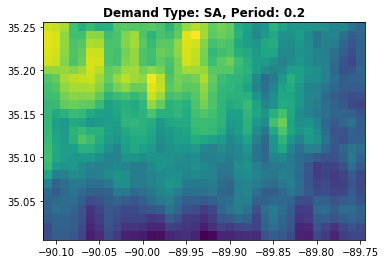

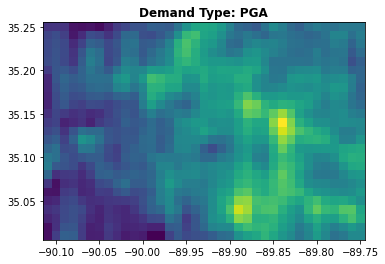

In [22]:
# Create an dataset-based earthquake with definition and files
eq_dataset_response = hazardsvc.create_earthquake(eq_dataset_json, file_paths)
print(json.dumps(eq_dataset_response, indent=4, sort_keys=False))

# Acquire hazard id from recently created hazard
eq_dataset_id = eq_dataset_response['id']
viz.plot_earthquake(eq_dataset_id, client, "0.2 SA")
viz.plot_earthquake(eq_dataset_id, client, "PGA")

In [23]:
# Obtain hazard value from your dataset-based earthquakes
points = [
    {
        "demands": ["0.2 SA"],
        "units": ["g"],
        "loc": "35.07899, -90.0178"
    },
    {
        "demands": ["PGA"],
        "units": ["g"],
        "loc": "35.027, -90.077"
    },
]
eq_dataset_vals = hazardsvc.post_earthquake_hazard_values(eq_dataset_id, points)
print(json.dumps(eq_dataset_vals, indent=4, sort_keys=False))

[
    {
        "hazardValues": [
            0.3610000014305115
        ],
        "demands": [
            "0.2 SA"
        ],
        "units": [
            "g"
        ],
        "loc": "35.07899, -90.0178"
    },
    {
        "hazardValues": [
            0.4519999921321869
        ],
        "demands": [
            "PGA"
        ],
        "units": [
            "g"
        ],
        "loc": "35.027, -90.077"
    }
]


### Session review

With the experience gained in this session, you should now be able to

* initialize ```IncoreClient``` and ```HazardService``` objects to authenticate to and access IN-CORE
resources,
* understand the workflow required to use existing hazard data, create new ones and use external datasets to perform new
hazard analyses
* apply these concepts to tornades and earthquakes within IN-CORE.

### Hands-on Assignment

For the next part of this session, please open [session2-assignment.ipynb](session2-assignment.ipynb).